In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




/kaggle/input/small-lcl-data/LCL-June2015v2_99.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_162.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_68.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_69.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_126.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_23.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_150.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_120.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_26.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_116.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_141.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_98.csv
/kaggle/input/full-london-smart-meters/Small LCL Data/LCL-June2015v2_73.csv
/kaggle/input/full-london-smart

In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#!pip install -U pip
#!pip install -U setuptools wheel

#!pip install autogluon


Creat two load forecasts...
1) half-hourly load forecast for next 24 hours
2) peak half-hour in the next 24 hours

Value...
* For electric network operator, minimize the amount of spinning reserve

Data...
* residential smart meter usage data
* weather data
* weather forecast data

In [4]:
# load half-hourly electric usage data
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
d = pd.read_csv('/kaggle/input/small-lcl-data/LCL-June2015v2_99.csv', parse_dates=["DateTime"])

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   LCLid                    1000000 non-null  object        
 1   stdorToU                 1000000 non-null  object        
 2   DateTime                 1000000 non-null  datetime64[ns]
 3   KWH/hh (per half hour)   1000000 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 30.5+ MB


In [6]:
# convert usage to floats
# print(d.iloc[3])
d.iloc[:, 3] = pd.to_numeric(d.iloc[:, 3], errors='coerce')
# print(d.dtypes)
# rename usage column for easier reference
#d.rename(columns={"KWH/hh (per half hour)": "KWHperHH"}, inplace=True)
d.rename(columns={d.columns[3]: 'KWHperHH'}, inplace=True)
# d.rename_col_by_index(3, 'KWHperHH')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   LCLid     1000000 non-null  object        
 1   stdorToU  1000000 non-null  object        
 2   DateTime  1000000 non-null  datetime64[ns]
 3   KWHperHH  999965 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 30.5+ MB


In [7]:
# set timestamp as the index
d.set_index('DateTime')


,LCLid,stdorToU,KWHperHH
DateTime,,,
2013-08-06 07:00:00,MAC004221,Std,0.046
2013-08-06 07:30:00,MAC004221,Std,0.040
2013-08-06 08:00:00,MAC004221,Std,0.016
2013-08-06 08:30:00,MAC004221,Std,0.018
2013-08-06 09:00:00,MAC004221,Std,0.016
...,...,...,...
2013-06-29 07:00:00,MAC004268,Std,0.151
2013-06-29 07:30:00,MAC004268,Std,0.278
2013-06-29 08:00:00,MAC004268,Std,0.128


In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(d, tsmode=True, sortby="DateTime")
profile.to_file('profile_report.html')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# visualize and handle duplicates
# d = d.drop_duplicates()
print(d.groupby(d.columns.tolist(),as_index=False).size())
dupes = d[d.duplicated()]
print('dupes', dupes)
print('dupes.index', dupes.index)
d = d.drop(index=dupes.index)

d.info()

            LCLid stdorToU            DateTime  KWHperHH  size
0       MAC004221      Std 2013-08-06 07:00:00     0.046     1
1       MAC004221      Std 2013-08-06 07:30:00     0.040     1
2       MAC004221      Std 2013-08-06 08:00:00     0.016     1
3       MAC004221      Std 2013-08-06 08:30:00     0.018     1
4       MAC004221      Std 2013-08-06 09:00:00     0.016     1
...           ...      ...                 ...       ...   ...
999282  MAC004268      Std 2013-06-29 07:00:00     0.151     1
999283  MAC004268      Std 2013-06-29 07:30:00     0.278     1
999284  MAC004268      Std 2013-06-29 08:00:00     0.128     1
999285  MAC004268      Std 2013-06-29 08:30:00     0.049     1
999286  MAC004268      Std 2013-06-29 09:00:00     0.129     1

[999287 rows x 5 columns]
            LCLid stdorToU   DateTime  KWHperHH
947     MAC004221      Std 2013-08-26     0.063
2434    MAC004221      Std 2013-09-26     0.041
3923    MAC004221      Std 2013-10-27     0.042
5412    MAC004221      St

In [10]:
d.set_index('DateTime')

,LCLid,stdorToU,KWHperHH
DateTime,,,
2013-08-06 07:00:00,MAC004221,Std,0.046
2013-08-06 07:30:00,MAC004221,Std,0.040
2013-08-06 08:00:00,MAC004221,Std,0.016
2013-08-06 08:30:00,MAC004221,Std,0.018
2013-08-06 09:00:00,MAC004221,Std,0.016
...,...,...,...
2013-06-29 07:00:00,MAC004268,Std,0.151
2013-06-29 07:30:00,MAC004268,Std,0.278
2013-06-29 08:00:00,MAC004268,Std,0.128


In [11]:
import seaborn as sns

DateTime   2012-05-23 10:30:00  2012-05-23 11:00:00  2012-05-23 11:30:00  \
LCLid                                                                      
MAC004221                  NaN                  NaN                  NaN   
MAC004222                0.382                0.311                0.212   
MAC004224                  NaN                0.213                0.458   
MAC004225                  NaN                0.112                0.113   
MAC004226                  NaN                0.163                0.035   
MAC004227                  NaN                0.347                0.241   
MAC004228                  NaN                  NaN                0.267   
MAC004230                  NaN                  NaN                0.241   
MAC004232                  NaN                  NaN                  NaN   
MAC004233                  NaN                  NaN                  NaN   
MAC004235                  NaN                  NaN                  NaN   
MAC004237   

<Axes: xlabel='DateTime', ylabel='LCLid'>

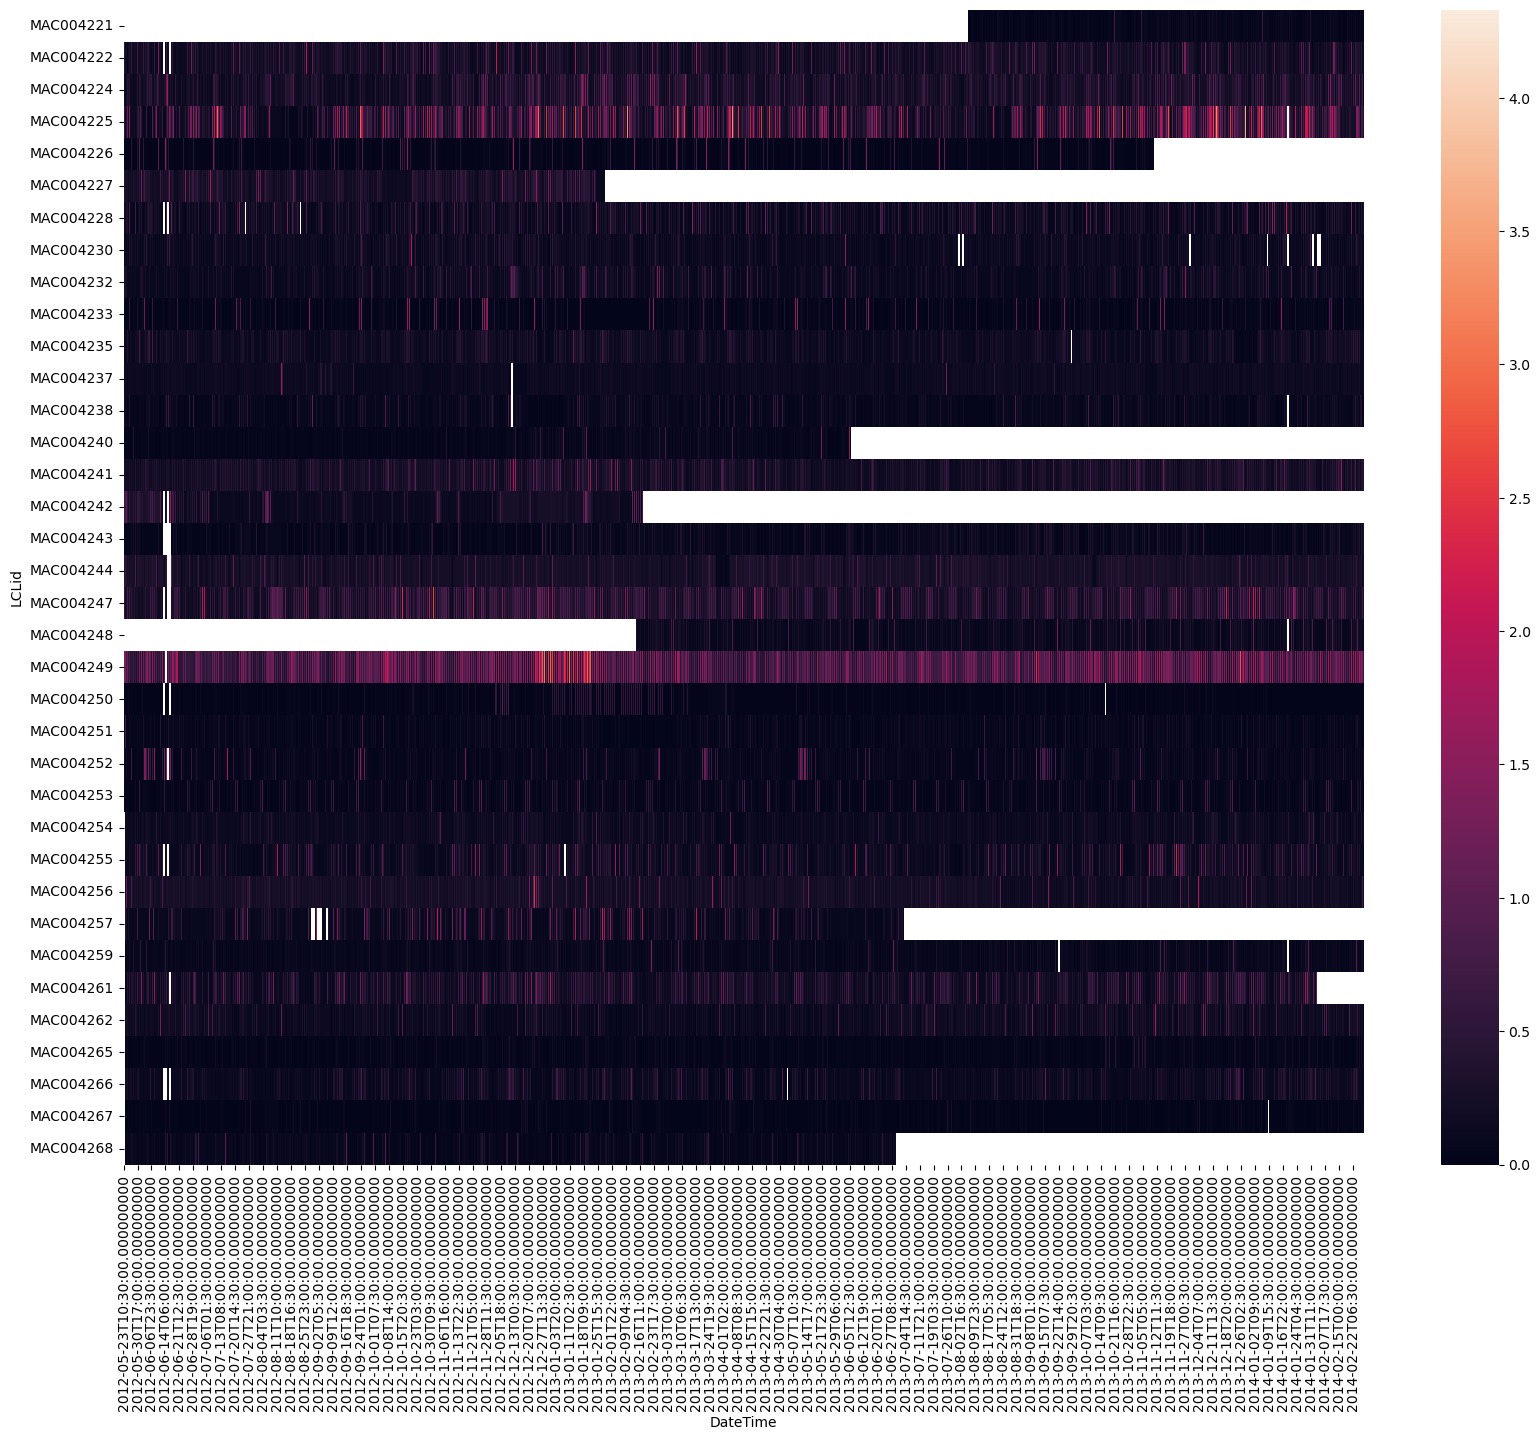

In [12]:
pivot_table = pd.pivot_table(d, columns='DateTime', index='LCLid', values='KWHperHH')
print(pivot_table)
plt.subplots(figsize=(20,15))
sns.heatmap(pivot_table)


Observations from Heatmap...
* several houses start producing load part-way through the period
    - eg MAC004221, MAC004248
    
    
* several houses stop producing part-way through the period
    - eg MAC004226, MAC004257
    

* most houses have at least one "gap" in their data (visible as white lines)


* several houses stand out as having significantly higher average load than others
    - eg MAC004225, MAC004249

In [14]:
# inspect and remove records not exactly on the half-hour
offRecs = d.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
# aggLoad["DateTime"].dt.hour > 30
print('Records not exactly on the half-hour: ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
d = d.drop(offRecs.index)

offRecs = d.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:              LCLid stdorToU            DateTime  KWHperHH
19832   MAC004222      Std 2012-12-18 15:19:59       NaN
50831   MAC004224      Std 2012-12-18 15:19:59       NaN
81839   MAC004225      Std 2012-12-18 15:20:00       NaN
112800  MAC004226      Std 2012-12-18 15:20:00       NaN
138570  MAC004227      Std 2012-12-18 15:20:00       NaN
150455  MAC004228      Std 2012-12-18 15:20:00       NaN
181460  MAC004230      Std 2012-12-18 15:20:00       NaN
212129  MAC004232      Std 2012-12-18 15:20:00       NaN
243135  MAC004233      Std 2012-12-18 15:20:00       NaN
274142  MAC004235      Std 2012-12-18 15:20:01       NaN
305076  MAC004237      Std 2012-12-18 15:20:01       NaN
336032  MAC004238      Std 2012-12-18 15:20:01       NaN
366986  MAC004240      Std 2012-12-18 15:20:01       NaN
385164  MAC004241      Std 2012-12-18 15:20:01       NaN
416071  MAC004242      Std 2012-12-18 15:20:01       NaN
428860  MAC004243      Std 2012-12-18 15:20:02   

DateTime   2012-05-23 10:30:00  2012-05-23 11:00:00  2012-05-23 11:30:00  \
LCLid                                                                      
MAC004221                  NaN                  NaN                  NaN   
MAC004222                0.382                0.311                0.212   
MAC004224                  NaN                0.213                0.458   
MAC004225                  NaN                0.112                0.113   
MAC004226                  NaN                0.163                0.035   
MAC004227                  NaN                0.347                0.241   
MAC004228                  NaN                  NaN                0.267   
MAC004230                  NaN                  NaN                0.241   
MAC004232                  NaN                  NaN                  NaN   
MAC004233                  NaN                  NaN                  NaN   
MAC004235                  NaN                  NaN                  NaN   
MAC004237   

<Axes: xlabel='DateTime', ylabel='LCLid'>

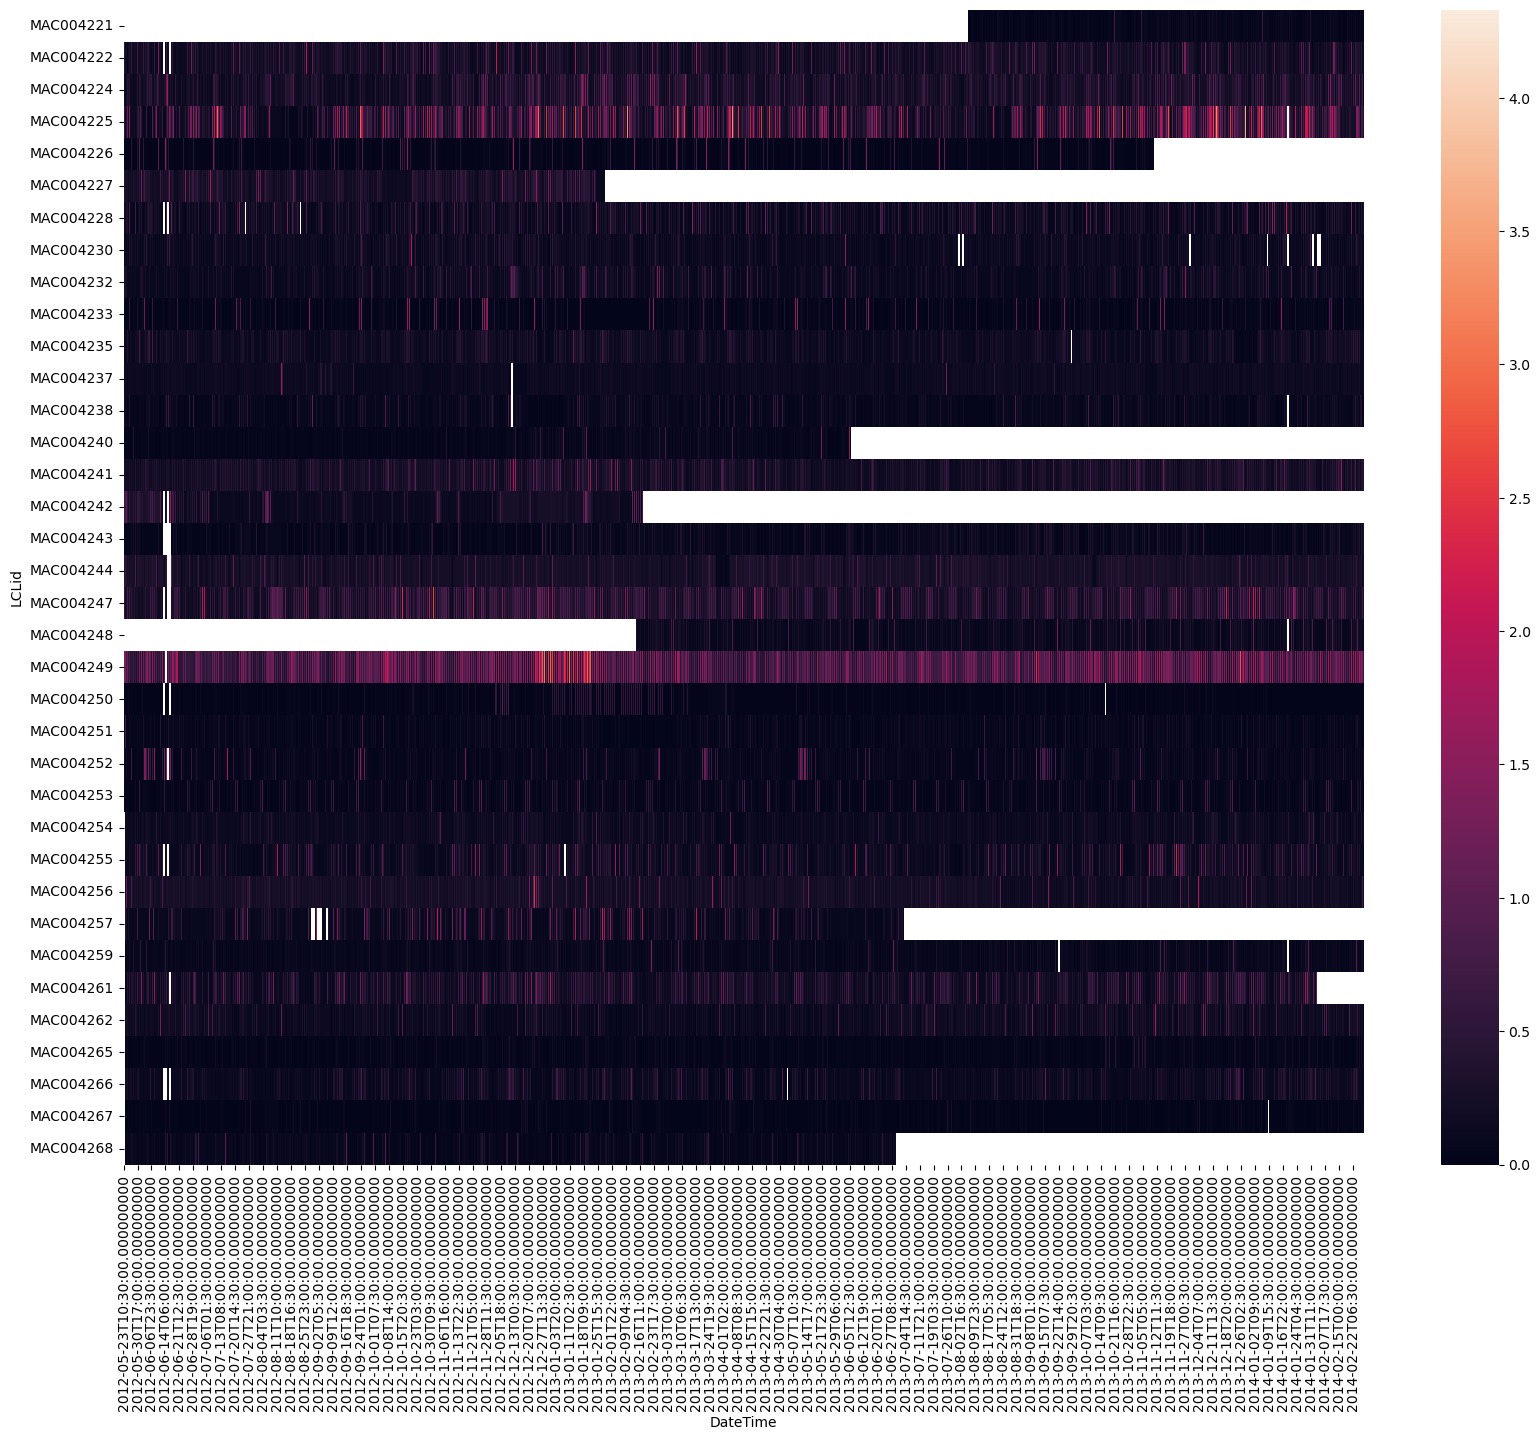

In [17]:
pivot_table = pd.pivot_table(d, columns='DateTime', index='LCLid', values='KWHperHH')
print(pivot_table)
plt.subplots(figsize=(20,15))
sns.heatmap(pivot_table)

In [ ]:
# find NaN
df = d[d['KWHperHH'].isna()]
print('NaN records:\n', df)

# interpolate / fill gaps???
for name, group in d.groupby('LCLid'):
    print(name)
    print(group)
    print('\n')
    
    # check for missing records in the aggregate load time series
    # create reference time series
    minTimestamp = group.DateTime.min()
    maxTimestamp = group.DateTime.max()

    print('minTimestamp: ', minTimestamp)
    print('maxTimestamp: ', maxTimestamp)

    date_range = pd.date_range(minTimestamp, maxTimestamp, freq='30Min')
    reference_df = pd.DataFrame(np.random.randint(1, 20, (date_range.shape[0], 1)))
    reference_df.index = date_range  # set index

    print('reference index length: ', reference_df.shape)
    print('group index length: ', group.shape)

    print('reference_df: ', reference_df)
    print('group: ', group)

    print('reference index: ', reference_df.index)
    print('group index: ', group.index)

    # check for missing datetimeindex values based on reference index (with all values)
    missing_dates = reference_df.index[~reference_df.index.isin(group.DateTime)]

    print('missing_dates:\n', missing_dates)
    
    # add NaN record for each missing date, which can then be populated with interpolation
    for missing_date in missing_dates:
        # create record with NaN value for KWHperHH
        rec = pd.DataFrame(
            {'LCLid': group.LCLid, 
             'stdorToU': group.stdorToU, 
             'DateTime': missing_date, 
             'KWHperHH': np.nan})
        
        print('rec:\n', rec)
        
        # concatenate the record
        d = pd.concat([d, rec], ignore_index=True)
    
    print('d.tail():\n', d.tail())

    z = group.KWHperHH.interpolate(limit=2, limit_area='inside')
    print('z:\n', z)
    
    # show interpolated values...
    print('d.tail() with interpolated values:\n', d.tail())
    
# a = d.groupby('LCLid')
a = d.groupby(pd.Grouper(key='LCLid'))
print('a: ', a.head())
b = a.KWHperHH
# b = a.interpolate(limit=2, limit_area='inside')
print('b: ', b.head())
# c = b.apply(pd.DataFrame.interpolate)
c = b.interpolate()
print('c: ', c.head())
# ['KWHperHH'].apply(pd.DataFrame.interpolate)

# for house in d.LCLid.unique():
    # print(d['MAC0']['KWHperHH'].interpolate(limit=2, limit_area='inside'))

NaN records:
 Empty DataFrame
Columns: [LCLid, stdorToU, DateTime, KWHperHH]
Index: []
MAC004221
          LCLid stdorToU            DateTime  KWHperHH
0     MAC004221      Std 2013-08-06 07:00:00     0.046
1     MAC004221      Std 2013-08-06 07:30:00     0.040
2     MAC004221      Std 2013-08-06 08:00:00     0.016
3     MAC004221      Std 2013-08-06 08:30:00     0.018
4     MAC004221      Std 2013-08-06 09:00:00     0.016
...         ...      ...                 ...       ...
9874  MAC004221      Std 2014-02-27 22:00:00     0.061
9875  MAC004221      Std 2014-02-27 22:30:00     0.086
9876  MAC004221      Std 2014-02-27 23:00:00     0.063
9877  MAC004221      Std 2014-02-27 23:30:00     0.060
9878  MAC004221      Std 2014-02-28 00:00:00     0.061

[9873 rows x 4 columns]


minTimestamp:  2013-08-06 07:00:00
maxTimestamp:  2014-02-28 00:00:00
reference index length:  (9875, 1)
group index length:  (9873, 4)
reference_df:                        0
2013-08-06 07:00:00  19
2013-08-06 07:30:

In [ ]:
# visualize and handle outliers

# minumum and maximum timestamp for each house
print(d.groupby('LCLid').max()) 
print(d.groupby('LCLid').min())
print(d.groupby('LCLid').count())

print(d.groupby('LCLid').max().sort_values('DateTime'))
print(d.groupby('LCLid').min().sort_values('DateTime'))
print(d.groupby('LCLid').count().sort_values('DateTime'))

print(d.groupby('LCLid').agg(['min', 'max', 'count']))


In [ ]:
# which house has the highest peak load?

# which house has the highest total aggregate load?

# how variable / predictable is the timing of the peak load

# how accurate is the next 24 hours forecast profile overall?

# how accurate is the peak load forecast in next 24 hours?

# normalize and standardize


In [ ]:
# extract one smartmeter for plotting
sample = d.query("LCLid == 'MAC004225'")
sample

In [ ]:
sample.iloc[:,3]
sample.iloc[:,2]

In [ ]:
# Visualize load profile for one household meter
fig, ax = plt.subplots()
ax.plot(sample.iloc[100:4500,2], sample.iloc[100:4500,3])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Load from one Household, June-September 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [ ]:
sample.head()

In [ ]:
sample.DateTime.dtype
sample.set_index('DateTime')

In [ ]:
# calculate sum of all loads
aggLoad = pd.DataFrame(columns=['DateTime', 'AggregateLoad'])
limit = 100
counter = 1
reportFreq = 1000
nUniqueTstamps = d.DateTime.unique().size
for tstamp in d.DateTime.unique():
    # print('tstamp: ', tstamp)
    tstampSum = d.loc[d['DateTime'] == tstamp].iloc[:,3].sum()
    row = {
    "DateTime": tstamp,
    "AggregateLoad": tstampSum
    }
    # print(row)
    # aggLoad = aggLoad.append(row, ignore_index=True)
    # Create an index for the DataFrame
    # index = pd.Index([1])
    index = pd.Index([1])
    
    # Create the DataFrame
    row_df = pd.DataFrame(row, index=index)

    # Concatenate `row_df` to `aggLoad`
    aggLoad = pd.concat([aggLoad, row_df], ignore_index=True)
    
    counter += 1
    
    if counter % reportFreq == 0:
        print('Progress: ', (counter / nUniqueTstamps)*100)
    
aggLoad

In [ ]:
aggLoad = aggLoad.sort_values(by=['DateTime'])
aggLoad = aggLoad.set_index('DateTime')
aggLoad.index.rename('DateTimeIndex', inplace=True)
aggLoad.info()

In [ ]:
aggLoad['DateTime'] = aggLoad.index
aggLoad.info()

In [ ]:
# inspect and fix records with zero load
# start with the aggregated records with zero load
AggZeros = aggLoad.query("AggregateLoad == 0")
AggZeros



Observation: Some of the timestamps are not exactly on the half-hour
Question: How many of the timestamps are not exactly on the half-hour?

In [ ]:
# inspect and fix records with zero load
# look at the raw records with zero load
# RawZeros = d.query("'KWH/hh (per half hour)' == 0")
# RawZeros

In [ ]:
# inspect and fix records not exactly on the half-hour
offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
# aggLoad["DateTime"].dt.hour > 30
print('Records not exactly on the half-hour: ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
aggLoad = aggLoad.drop(offRecs.index)

offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

In [ ]:
# check for missing records in the aggregate load time series
# create reference time series
minTimestamp = aggLoad.index.min()
maxTimestamp = aggLoad.index.max()

print('minTimestamp: ', minTimestamp)
print('maxTimestamp: ', maxTimestamp)

date_range = pd.date_range(minTimestamp, maxTimestamp, freq='30Min')
reference_df = pd.DataFrame(np.random.randint(1, 20, (date_range.shape[0], 1)))
reference_df.index = date_range  # set index

print('reference index length: ', reference_df.shape)
print('aggLoad index length: ', aggLoad.shape)

print('reference_df: ', reference_df)
print('aggLoad: ', aggLoad)

print('reference index: ', reference_df.index)
print('aggLoad index: ', aggLoad.index)

# check for missing datetimeindex values based on reference index (with all values)
missing_dates = reference_df.index[~reference_df.index.isin(aggLoad.index)]

print('missing_dates: ', missing_dates)

In [ ]:
print(aggLoad)

fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad)

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [ ]:
aggLoad.head()


In [ ]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[10000:15000], aggLoad.AggregateLoad[10000:15000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load June-August 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12000:13000], aggLoad.AggregateLoad[12000:13000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12600], aggLoad.AggregateLoad[12500:12600])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load ~two days')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12550], aggLoad.AggregateLoad[12500:12550])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load (one day)')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("test.png")
plt.show()

Create a Deep Learning time series forecasting model using Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras


In [ ]:
# RNN

In [ ]:
# LSTM

In [ ]:
# CNN-LSTM

AutoGluon TimeSeries Sample

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()

In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

In [ ]:
predictions = predictor.predict(train_data)
predictions.head()

In [ ]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

item_id = "H1"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

In [ ]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data, silent=True)

AutoGluon with our dataset

In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


In [ ]:
aggLoad.head()

In [ ]:
profile = ProfileReport(d, tsmode=True, sortby="DateTime")
profile.to_file('profile_report.html')
profile

In [ ]:
# AutoGluon requires and ItemID Column, so adding one...
aggLoad['item_id'] = 'LoadSum'
aggLoad = aggLoad.astype({"item_id": str})

# Split the time series data into train, test, and validation datasets
train_size = int(len(aggLoad) * 0.8)  # 70% for training
test_size = int(len(aggLoad) * 0.1)   # 20% for testing
val_size = len(aggLoad) - train_size - test_size  # Remaining for validation

train_data = aggLoad[:train_size]
test_data = aggLoad[train_size:train_size+test_size]
val_data = aggLoad[train_size+test_size:]

print('train_data.head()', train_data.head())
print('test_data.head()', test_data.head())
print('val_data.head()', val_data.head())
print(train_data.info())



In [ ]:
# check the regularity of the observations (time between observations)
# print(pd.infer_freq(train_data.DateTime))
aggLoad.index.to_series().diff().value_counts()

In [ ]:
print(train_data.info())
train_data_tsdf = TimeSeriesDataFrame.from_data_frame(
    train_data,
    id_column="item_id",
    timestamp_column="DateTime"
)
train_data_tsdf

In [ ]:
test_data_tsdf = TimeSeriesDataFrame.from_data_frame(
    test_data,
    id_column="item_id",
    timestamp_column="DateTime"
)
test_data_tsdf

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="AggregateLoad",
    eval_metric="MASE",
)

predictor.fit(
    train_data_tsdf,
    presets="high_quality",
    time_limit=6000,
)

In [ ]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data_tsdf, silent=True)

In [ ]:
predictions = predictor.predict(train_data_tsdf)
predictions.head()

In [ ]:
plt.figure(figsize=(20, 3))

item_id = "LoadSum"
y_past = train_data_tsdf.loc[item_id]["AggregateLoad"]
y_pred = predictions.loc[item_id]
y_test = test_data_tsdf.loc[item_id]["AggregateLoad"]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test[:48], label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();